# Violin and Precision-Recall Curve Analysis

This script provides functionality for generating violin plots and precision-recall (PR) curves for evaluating model performance. It includes customizable options for visualization, dataset summaries, and statistical comparisons.

# Initialization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Successfully loaded color dictionary with 24 entries
Successfully loaded line dictionary with 6 entries
Successfully loaded list dictionary with 8 entries


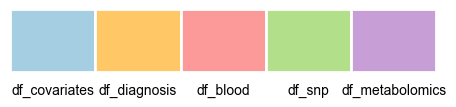

In [3]:
import sys
import yaml
sys.path.append("../../modeling_pipeline") #Because the project is in a different folder (two levels up), we need to add the path to the sys path
sys.path.append("../..")

%load_ext autoreload
%autoreload 2

from modeling_pipeline.pipeline import * #Load our package with classes pipeline, models, pp (preprocessing), plot, and more

#This allows us to automatically reload the packages we are working on in the background, no "Restart Kernel" needed



############### CHANGE THIS ############
path= pp.userpath(os.environ.get("USER", os.environ.get("USERNAME")), project="cca") # Choose your own project here, only works if you added specific project in user_settings.json
############### CHANGE THIS ############


fig_path = f"{path}/visuals"
AUPRC_path = f"{fig_path}/AUPRCs"
if not os.path.exists(AUPRC_path):
    os.makedirs(AUPRC_path)

# Load the default color dictionary
yaml_colors_path = "custom_colors.yaml"
with open(yaml_colors_path, 'r') as file:
    config = yaml.safe_load(file)

scenarios_colors = config.get("scenarios_colors", {}) # Extract the color dictionary
print("Successfully loaded color dictionary with", len(scenarios_colors), "entries")

line_styles = config.get("line_styles", {}) # Extract the line styles dictionary
print("Successfully loaded line dictionary with", len(line_styles), "entries")

scenario_lists = config.get("scenario_lists", {}) # Extract the scenario lists
print("Successfully loaded list dictionary with", len(scenario_lists), "entries")
title_dict = config.get("title_dict", {}) # Extract the title dictionary
colors_PRC = config.get("colors_PRC", {}) # Extract the color dictionary
color_map= config.get("color_map_hex", {}) # Extract the color dictionary

plot_colorbar(color_map)

In [4]:
all_tprs = load_tprs(path,["RFC","CatBoost"])
all_preds = load_prediction_values(path, ["RFC","CatBoost"])

Loaded joblib TPRs for RFC
Loaded joblib TPRs for CatBoost
Loaded predictions for RFC_all_cca_Model_TOP5 from joblib from C:/Users/felix/OneDrive - Uniklinik RWTH Aachen/CRC-1382-A11 - drive/public/projects/cca/Models/Pipelines/RFC\combined_output/val/Prediction_values_combined.joblib
Loaded predictions for RFC_all_cca_Model_TOP10 from joblib from C:/Users/felix/OneDrive - Uniklinik RWTH Aachen/CRC-1382-A11 - drive/public/projects/cca/Models/Pipelines/RFC\combined_output/val/Prediction_values_combined.joblib
Loaded predictions for RFC_all_cca_Model_C from joblib from C:/Users/felix/OneDrive - Uniklinik RWTH Aachen/CRC-1382-A11 - drive/public/projects/cca/Models/Pipelines/RFC\combined_output/val/Prediction_values_combined.joblib
Loaded predictions for RFC_all_cca_Model_A from joblib from C:/Users/felix/OneDrive - Uniklinik RWTH Aachen/CRC-1382-A11 - drive/public/projects/cca/Models/Pipelines/RFC\combined_output/val/Prediction_values_combined.joblib
Loaded predictions for RFC_all_cca_Mod

# Customization



## Customization Options
- **Color Schemes:** Uses predefined or custom colors.
- **Figure Layout:** Adjustable grid layout (rows/columns).
- **Labeling:** Supports automatic and user-defined labels.
- **Plot Styles:** Various styles including line thickness, transparency, and split visualization.

### Color Schemes

The framework uses a YAML file (`default_colors.yaml`) to define color schemes for different scenarios:

```yaml
scenarios_colors:
  A: '#8A2BE2'  # BlueViolet
  B: '#FF7F50'  # Coral
  C: '#20B2AA'  # LightSeaGreen
  # More colors...



# Data Import

### Prediction Data
Load your prediction score data from our modelling pipeline. This takes some time to load (30 - 60s) as we need the raw prediction data of > 500.000 people...

If using the pipeline with independent data, make sure your files adhere to this format:

|    eid   | status | status_cancerreg |  y_pred   | SEX |
|----------|--------|------------------|-----------|-----|
| 1000000  |   0    |         0        |   0.33    |  0  |
| 1000000  |   0    |         0        | 0.247354  |  1  |
| 1000000  |   0    |         0        | 0.421570  |  0  |
| 1000100  |   0    |         0        | 0.360414  |  0  |
| ...      |        |                  |           |     |
| 9999999  |   0    |         0        | 0.373559  |  1  |


## PLAYGROUND


In [ ]:
all_predictions1 = load_prediction_values(["CatBoost", "RFC"], path)

In [ ]:
def plot_predicted_scores_vs_difftime(
    predictions_dict,
    model_key,
    hue_column=None,
    fig_path=None,
    fig_title="Predicted_scores_vs_time_difference_positive_cases.svg"
):
    """
    Plot predicted scores vs. time difference for positive cancer registry cases.

    Parameters:
    - predictions_dict: dict, contains model prediction DataFrames keyed by model names
    - model_key: str, the key to select the specific model's DataFrame from predictions_dict
    - hue_column: str or None, optional column name to use as hue in the plot
    - fig_path: str or None, path to save the figure (directory only, not full filename)
    - fig_title: str, filename to save the figure as (supports .svg, .png, etc.)
    """

    columns_to_extract = ["eid", "status","SEX", "status_cancerreg", "y_pred", "difftime"]
    df_combined = pd.concat([predictions_dict[model_key][columns_to_extract]])

    # Filter for positive cancer registry cases and invert time difference
    positive_cases = df_combined[df_combined["status_cancerreg"] == 1].copy()
    positive_cases["difftime"] = -positive_cases["difftime"]

    # Set up the plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x="difftime",
        y="y_pred",
        data=positive_cases,
        hue=hue_column if hue_column in positive_cases.columns else None,
        alpha=0.7
    )

    # Labels and title
    plt.xlabel("Time Difference (difftime)", fontsize=14)
    plt.ylabel("Predicted Values (y_pred)", fontsize=14)
    plt.title("Predicted Scores vs. Time Difference for Positive Cases", fontsize=16)

    # Optional legend
    if hue_column in positive_cases.columns:
        plt.legend(title=hue_column)

    # Show and/or save
    plt.tight_layout()
    if fig_path is not None:
        save_figure(plt, fig_path=fig_path, title=fig_title, fig_type="Scatterplot")
    plt.show()

In [ ]:
#
#TODO Binäres color coding ( hue für sex, ethnicity, diagnosis ? )
#TODO Scatterplot in plot.py einfügen
#TODO RAG plot seaborn einfügen?
# Extract specific columns from the dictionary into one dataframe
columns_to_extract = ["eid","status", "status_cancerreg", "y_pred", "difftime"]
df_combined = pd.concat([all_predictions["CatBoost_all_cca_Model_TOP5"][columns_to_extract]])# Filter the DataFrame for positive cases (status_cancerreg == 1)


positive_cases = df_combined[df_combined["status_cancerreg"] == 1]
positive_cases["difftime"] = positive_cases["difftime"] * -1 # Invert the difftime for positive cases

# Plot difftime on the x-axis and y_pred on the y-axis
plt.figure(figsize=(10, 6))
sns.scatterplot(x="difftime", y="y_pred", data=positive_cases, color="blue", alpha=0.7)

# Add labels and title
plt.xlabel("Time Difference (difftime)", fontsize=14)
plt.ylabel("Predicted Values (y_pred)", fontsize=14)
plt.title("Predicted Scores vs. Time Difference for Positive Cases", fontsize=16)

# Show the plot
plt.show()
save_figure(plt, fig_path=fig_path,title="Predicted_scores_vs_time_difference_positive_cases.svg" ,fig_type="Scatterplot")

In [ ]:
# Add a column to differentiate cases and controls
df_combined["case_control"] = df_combined["status_cancerreg"].apply(lambda x: "Case" if x == 1 else "Control")
df_combined["difftime"] = df_combined["difftime"] * -1  # Invert the difftime for all cases

# Plot difftime on the x-axis and y_pred on the y-axis, colored by case/control
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="difftime",
    y="y_pred",
    hue="case_control",
    data=df_combined,
    palette={"Case": "blue", "Control": "orange"},
    alpha=0.7
)

# Add labels, legend, and title
plt.xlabel("Time Difference (difftime)", fontsize=14)
plt.ylabel("Predicted Values (y_pred)", fontsize=14)
plt.title("Predicted Scores vs. Time Difference (Cases vs. Controls)", fontsize=16)
plt.legend(title="Group", fontsize=12)

# Show the plot
plt.show()

In [ ]:
plt.hist(df["y_pred"], bins=50)
plt.xlabel('Predicted probability')
plt.ylabel('Frequency')
plt.title('Distribution of CatBoost predictions')
plt.xlim(0, 0.05)
plt.show()

### Data for Benchmark Performance 

Choose literature benchmarks/other models and load them as df_benchmark with y_pred (the prediction scores), the status (ground truth) and ideally info on SEX for stratification analysis

#### Import and merge additional information (Sex, other diagnoses) for subsetting in plots

In [ ]:
#Import sex info and merge onto dataframes for sex-stratified analysis
import pyreadr
df_diagnosis = pyreadr.read_r('C:/Users/felix/OneDrive - Uniklinik RWTH Aachen/public/projects/cca/data/dataframes/df_diagnosis.RData')
df_diagnosis = df_diagnosis["df_diagnosis"]


df_sex = pd.read_csv(path+'/data/dataframes/df_covariates.csv')
df_sex = df_sex[['eid', 'SEX']]
for key in all_predictions:
    if "eid" in all_predictions[key].columns:
        all_predictions[key] = pd.merge(all_predictions[key], df_sex, on="eid")
        all_predictions[key] = pd.merge(all_predictions[key], df_diagnosis, on='eid')


In [ ]:


benchmark_all = pd.read_csv(path + '/data/dataframes/df_benchmark.csv')

# List of scores to process
scores = ["aMAP", "APRI", "FIB4", "NFS", "Liver cirrhosis"]

for score in scores:
    # Create a copy of the benchmark dataframe
    df_temp = benchmark_all.copy()

    # Rename columns
    df_temp = df_temp.rename(columns={
        score: 'y_pred',
        'gender' : 'SEX'
    })

    # Select only the required columns
    df_temp = df_temp[['y_pred', 'status', 'status_cancerreg', 'SEX']]

    # Add to dataframes dictionary
    dataframes[f'all_{score}'] = df_temp

    print(f"all_{score} added to dataframes. Loading next score.")

print("All scores added to dataframes.")


# # Import individual benchmark scores and append them to dataframes dictionary
# amap_all=pd.read_csv(path+'/data/dataframes/df_amap.csv')
# amap_par=pd.read_csv(path+'/data/dataframes/df_amap_par.csv')
# amap_all.rename(columns={'aMAP': 'y_pred', 'gender' : "SEX"}, inplace=True)
# amap_par.rename(columns={'aMAP': 'y_pred', 'gender' : "SEX"}, inplace=True)
# dataframes['all_aMAP'] = amap_all[['y_pred', 'status', 'status_cancerreg', "SEX"]]
# dataframes['par_aMAP'] = amap_par[['y_pred', 'status', 'status_cancerreg', "SEX"]]

# Verify the additions
for key in dataframes.keys():
    if key.startswith('all_'):
        print(f"{key}: {dataframes[key].shape}")

dataframes.keys()

### Double check dataframes

In [ ]:
summary_df = summarize_dataframes(dataframes)
summary_df = summary_df.sort_values('Rows', ascending=False) #Sort table
print(summary_df.to_string(index=False))
#summary_df.to_csv('dataframes_summary.csv', index=False)

# Violin Plots

- Generates violin plots for visualizing the distribution of predicted probabilities.
- Supports:
  - Custom color schemes
  - Splitting by sex
  - Adjustable figure layout (rows/columns)
  - Custom labeling and styling
  - Saving plots in SVG format

In [ ]:
pl=load_Pipeline(path + "/Models/Pipelines/CatBoost/Pipeline_CCA_all_cca_Model_TOP5_CatBoost.joblib") #Change for pipeline you want

### All

This reflects a constellation of both the incremental (A-E) as the separate models. Only works if you have trained all of these model constellations

In [ ]:
keys_ordered_all=['all_cca_Model_Demographics', 'all_cca_Model_Diagnosis', 'all_cca_Model_Blood', 'all_cca_Model_SNP', 'all_cca_Model_Metabolomics', 'all_cca_Model_A', 'all_cca_Model_B', 'all_cca_Model_C','all_cca_Model_D', 'all_cca_Model_E',]
color_dict_all={'all_cca_Model_A'                   :color_map["df_covariates"],
            'all_cca_Model_B'                   :color_map['df_diagnosis'],
            'all_cca_Model_C'                   :color_map["df_blood"],
            'all_cca_Model_D'                   :color_map["df_snp"],
            'all_cca_Model_E'                   :color_map['df_metabolomics'],


            'all_cca_Model_Demographics'        :color_map["df_covariates"],
            'all_cca_Model_Diagnosis'          :color_map["df_diagnosis"],
            'all_cca_Model_Blood'               :color_map["df_blood"],
            'all_cca_Model_SNP'                 :color_map['df_snp'],
            'all_cca_Model_Metabolomics'        :color_map['df_metabolomics']}

title_dict_all={'all_cca_Model_A'                   :'Model A',
            'all_cca_Model_B'                   :'Model B',
            'all_cca_Model_C'                   :'Model C',
            'all_cca_Model_D'                   :'Model D',
            'all_cca_Model_E'                   :'Model E',


            'all_cca_Model_Demographics'        :'Demographics',
            'all_cca_Model_Diagnosis'          :'Diagnosis',
            'all_cca_Model_Blood'               :'Blood',
            'all_cca_Model_SNP'                 :'Genomics',
            'all_cca_Model_Metabolomics'        :'Metabolomics'}

create_violin_plots(dataframes=dataframes, keys_ordered=keys_ordered_all, color_dict=color_dict_all, title_dict=title_dict_all, display="all", title_display="All", inner_detail="quart", n_cols=10, gap=0, truth="status_cancerreg")

##### All only incremental models

In [ ]:
keys_ordered_all=[ 'CatBoost_all_cca_Model_C']
color_dict_all={
            'CatBoost_all_cca_Model_C'                   :color_map["df_blood"]}



title_dict_all={
            'CatBoost_all_cca_Model_C'                   :'CatBoost - Model C',
}




create_violin_plots(dataframes=all_predictions, keys_ordered=keys_ordered_all, color_dict=color_dict_all,
                    title_dict=title_dict_all, display="all_inc", title_display="All", inner_detail="quart",
                    n_cols=5, gap=0, split_by_sex=False, truth="status_cancerreg", fig_path=fig_path)

In [ ]:
keys_ordered_all=['CatBoost_all_cca_Model_A', 'CatBoost_all_cca_Model_B', 'CatBoost_all_cca_Model_C','CatBoost_all_cca_Model_D', 'CatBoost_all_cca_Model_E',]
color_dict_all={'CatBoost_all_cca_Model_A'                   :color_map["df_covariates"],
            'CatBoost_all_cca_Model_B'                   :color_map['df_diagnosis'],
            'CatBoost_all_cca_Model_C'                   :color_map["df_blood"],
            'CatBoost_all_cca_Model_D'                   :color_map["df_snp"],
            'CatBoost_all_cca_Model_E'                   :color_map['df_metabolomics'],}


title_dict_all={'CatBoost_all_cca_Model_A'                   :'Model A',
            'CatBoost_all_cca_Model_B'                   :'Model B',
            'CatBoost_all_cca_Model_C'                   :'Model C',
            'CatBoost_all_cca_Model_D'                   :'Model D',
            'CatBoost_all_cca_Model_E'                   :'Model E',}




create_violin_plots(dataframes=all_predictions, keys_ordered=keys_ordered_all, color_dict=color_dict_all,
                    title_dict=title_dict_all, display="all_inc_CatBoost", title_display="All CatBoost", inner_detail="quart",
                    n_cols=5, gap=0, split_by_sex=False, truth="status_cancerreg", fig_path=fig_path,
                    highlight_column="Liver cirrhosis")

In [ ]:
keys_ordered_all=['CatBoost_par_cca_Model_A', 'CatBoost_par_cca_Model_B', 'CatBoost_par_cca_Model_C','CatBoost_par_cca_Model_D', 'CatBoost_par_cca_Model_E',]
color_dict_all={'CatBoost_par_cca_Model_A'              :color_map["df_covariates"],
            'CatBoost_par_cca_Model_B'                   :color_map['df_diagnosis'],
            'CatBoost_par_cca_Model_C'                   :color_map["df_blood"],
            'CatBoost_par_cca_Model_D'                   :color_map["df_snp"],
            'CatBoost_par_cca_Model_E'                   :color_map['df_metabolomics'],}

title_dict_all={'CatBoost_par_cca_Model_A'                   :'Model A',
            'CatBoost_par_cca_Model_B'                   :'Model B',
            'CatBoost_par_cca_Model_C'                   :'Model C',
            'CatBoost_par_cca_Model_D'                   :'Model D',
            'CatBoost_par_cca_Model_E'                   :'Model E',}


create_violin_plots(dataframes=all_predictions1, keys_ordered=keys_ordered_all, color_dict=color_dict_all,
                    title_dict=title_dict_all, display="par_inc_CatBoost", title_display="PAR CatBoost", inner_detail="quart",
                    n_cols=5, gap=0, split_by_sex=False, truth="status_cancerreg", fig_path=fig_path)

### Incremental RFC All

In [ ]:
keys_ordered_all=['RFC_all_cca_Model_A', 'RFC_all_cca_Model_B', 'RFC_all_cca_Model_C','RFC_all_cca_Model_D', 'RFC_all_cca_Model_E',]
color_dict_all={'RFC_all_cca_Model_A'              :color_map["df_covariates"],
            'RFC_all_cca_Model_B'                   :color_map['df_diagnosis'],
            'RFC_all_cca_Model_C'                   :color_map["df_blood"],
            'RFC_all_cca_Model_D'                   :color_map["df_snp"],
            'RFC_all_cca_Model_E'                   :color_map['df_metabolomics'],}

title_dict_all={'RFC_all_cca_Model_A'                   :'Model A',
            'RFC_all_cca_Model_B'                   :'Model B',
            'RFC_all_cca_Model_C'                   :'Model C',
            'RFC_all_cca_Model_D'                   :'Model D',
            'RFC_all_cca_Model_E'                   :'Model E',}


create_violin_plots(dataframes=all_predictions1, keys_ordered=keys_ordered_all, color_dict=color_dict_all,
                    title_dict=title_dict_all, display="all_inc_RFC", title_display="All RFC", inner_detail="quart",
                    n_cols=5, gap=0, split_by_sex=False, truth="status_cancerreg", fig_path=fig_path)

### Incremental RFC PAR

In [ ]:
keys_ordered_all=['RFC_par_cca_Model_A', 'RFC_par_cca_Model_B', 'RFC_par_cca_Model_C','RFC_par_cca_Model_D', 'RFC_par_cca_Model_E',]
color_dict_all={'RFC_par_cca_Model_A'              :color_map["df_covariates"],
            'RFC_par_cca_Model_B'                   :color_map['df_diagnosis'],
            'RFC_par_cca_Model_C'                   :color_map["df_blood"],
            'RFC_par_cca_Model_D'                   :color_map["df_snp"],
            'RFC_par_cca_Model_E'                   :color_map['df_metabolomics'],}

title_dict_all={'RFC_par_cca_Model_A'                   :'Model A',
            'RFC_par_cca_Model_B'                   :'Model B',
            'RFC_par_cca_Model_C'                   :'Model C',
            'RFC_par_cca_Model_D'                   :'Model D',
            'RFC_par_cca_Model_E'                   :'Model E',}


create_violin_plots(dataframes=all_predictions, keys_ordered=keys_ordered_all, color_dict=color_dict_all,
                    title_dict=title_dict_all, display="par_inc_RFC", title_display="PAR RFC", inner_detail="quart",
                    n_cols=5, gap=0, split_by_sex=False, truth="status_cancerreg", fig_path=fig_path)

Incremental RFC Unscreened

In [ ]:
keys_ordered_all=['RFC_unscreened_cca_Model_A', 'RFC_unscreened_cca_Model_B', 'RFC_unscreened_cca_Model_C','RFC_unscreened_cca_Model_D', 'RFC_unscreened_cca_Model_E',]
color_dict_all={'RFC_unscreened_cca_Model_A'              :color_map["df_covariates"],
            'RFC_unscreened_cca_Model_B'                   :color_map['df_diagnosis'],
            'RFC_unscreened_cca_Model_C'                   :color_map["df_blood"],
            'RFC_unscreened_cca_Model_D'                   :color_map["df_snp"],
            'RFC_unscreened_cca_Model_E'                   :color_map['df_metabolomics'],}

title_dict_all={'RFC_unscreened_cca_Model_A'                   :'Model A',
            'RFC_unscreened_cca_Model_B'                   :'Model B',
            'RFC_unscreened_cca_Model_C'                   :'Model C',
            'RFC_unscreened_cca_Model_D'                   :'Model D',
            'RFC_unscreened_cca_Model_E'                   :'Model E',}


create_violin_plots(dataframes=all_preds, keys_ordered=keys_ordered_all, color_dict=color_dict_all,
                    title_dict=title_dict_all, display="unscreened_inc_RFC", title_display="unscreened RFC", inner_detail="quart",
                    n_cols=5, gap=0, split_by_sex=False, truth="status_cancerreg", fig_path=fig_path)

##### All only separate models

In [ ]:
keys_ordered_all=['all_cca_Model_Demographics', 'all_cca_Model_Diagnosis', 'all_cca_Model_Blood', 'all_cca_Model_SNP', 'all_cca_Model_Metabolomics',]
color_dict_all={'all_cca_Model_Demographics'        :color_map["df_covariates"],
            'all_cca_Model_Diagnosis'          :color_map["df_diagnosis"],
            'all_cca_Model_Blood'               :color_map["df_blood"],
            'all_cca_Model_SNP'                 :color_map['df_snp'],
            'all_cca_Model_Metabolomics'        :color_map['df_metabolomics']}


title_dict_all={'all_cca_Model_Demographics'        :'Demographics',
            'all_cca_Model_Diagnosis'          :'Diagnosis',
            'all_cca_Model_Blood'               :'Blood',
            'all_cca_Model_SNP'                 :'Genomics',
            'all_cca_Model_Metabolomics'        :'Metabolomics'}

create_violin_plots(dataframes=dataframes, keys_ordered=keys_ordered_all, color_dict=color_dict_all,
                    title_dict=title_dict_all, display="all_sep", title_display="All", inner_detail="quart",
                    n_cols=5, gap=0, split_by_sex=False, truth="status_cancerreg", fig_path=fig_path)

##### All strat. sex

In [ ]:
keys_ordered_all=['all_cca_Model_A', 'all_cca_Model_B', 'all_cca_Model_C','all_cca_Model_D', 'all_cca_Model_E',]
color_dict_all={'all_cca_Model_A'                   :color_map["df_covariates"],
            'all_cca_Model_B'                   :color_map['df_diagnosis'],
            'all_cca_Model_C'                   :color_map["df_blood"],
            'all_cca_Model_D'                   :color_map["df_snp"],
            'all_cca_Model_E'                   :color_map['df_metabolomics'],}


title_dict_all={'all_cca_Model_A'                   :'Model A',
            'all_cca_Model_B'                   :'Model B',
            'all_cca_Model_C'                   :'Model C',
            'all_cca_Model_D'                   :'Model D',
            'all_cca_Model_E'                   :'Model E',}

create_violin_plots(dataframes=dataframes, keys_ordered=keys_ordered_all, color_dict=color_dict_all,
                    title_dict=title_dict_all, display="all_sex", title_display="All", inner_detail="quart",
                    n_cols=5, gap=0, split_by_sex=True, truth="status_cancerreg", fig_path=fig_path)

### PAR

In [ ]:
keys_ordered_par=['par_Model_Demographics', 'par_Model_Diagnosis', 'par_Model_Blood', 'par_Model_SNP', 'par_Model_Metabolomics', 'par_Model_A', 'par_Model_B', 'par_Model_C','par_Model_D', 'par_Model_E']
color_dict_par={'par_Model_A'                   :color_map["df_covariates"],
            'par_Model_B'                   :color_map['df_diagnosis'],
            'par_Model_C'                   :color_map["df_blood"],
            'par_Model_D'                   :color_map["df_snp"],
            'par_Model_E'                   :color_map['df_metabolomics'],


            'par_Model_Demographics'        :color_map["df_covariates"],
            'par_Model_Diagnosis'          :color_map["df_diagnosis"],
            'par_Model_Blood'               :color_map["df_blood"],
            'par_Model_SNP'                 :color_map['df_snp'],
            'par_Model_Metabolomics'        :color_map['df_metabolomics']}

title_dict_par={'par_Model_A'                   :'Model A',
            'par_Model_B'                   :'Model B',
            'par_Model_C'                   :'Model C',
            'par_Model_D'                   :'Model D',
            'par_Model_E'                   :'Model E',


            'par_Model_Demographics'        :'Demographics',
            'par_Model_Diagnosis'          :'Diagnosis',
            'par_Model_Blood'               :'Blood',
            'par_Model_SNP'                 :'Genomics',
            'par_Model_Metabolomics'        :'Metabolomics'}


create_violin_plots(dataframes=dataframes, keys_ordered=keys_ordered_par, color_dict=color_dict_par,
                    title_dict=title_dict_par, title_display="Chronic Liver Disease", display="par",
                    n_cols=10, gap=0, truth="status_cancerreg", fig_path=fig_path)

##### PAR only incremental

In [ ]:
keys_ordered_par_sex=['par_Model_A', 'par_Model_B', 'par_Model_C','par_Model_D', 'par_Model_E']
color_dict_par={'par_Model_A'                   :color_map["df_covariates"],
            'par_Model_B'                   :color_map['df_diagnosis'],
            'par_Model_C'                   :color_map["df_blood"],
            'par_Model_D'                   :color_map["df_snp"],
            'par_Model_E'                   :color_map['df_metabolomics']
            }


title_dict_par={'par_Model_A'                   :'Model A',
            'par_Model_B'                   :'Model B',
            'par_Model_C'                   :'Model C',
            'par_Model_D'                   :'Model D',
            'par_Model_E'                   :'Model E',
            }

create_violin_plots(dataframes=dataframes, keys_ordered=keys_ordered_par_sex, color_dict=color_dict_par,
                    title_dict=title_dict_par, display="par_inc", title_display="Chronic Liver Disease",
                    n_cols=5, gap=0, split_by_sex=False, fig_path=fig_path,
                    highlight_column="Liver cirrhosis")

##### Par only separate

In [ ]:
keys_ordered_par=['par_Model_Demographics', 'par_Model_Diagnosis', 'par_Model_Blood', 'par_Model_SNP', 'par_Model_Metabolomics',]
color_dict_par={'par_Model_Demographics'        :color_map["df_covariates"],
            'par_Model_Diagnosis'          :color_map["df_diagnosis"],
            'par_Model_Blood'               :color_map["df_blood"],
            'par_Model_SNP'                 :color_map['df_snp'],
            'par_Model_Metabolomics'        :color_map['df_metabolomics']}


title_dict_par={'par_Model_Demographics'        :'Demographics',
            'par_Model_Diagnosis'          :'Diagnosis',
            'par_Model_Blood'               :'Blood',
            'par_Model_SNP'                 :'Genomics',
            'par_Model_Metabolomics'        :'Metabolomics'}

create_violin_plots(dataframes=dataframes, keys_ordered=keys_ordered_par, color_dict=color_dict_par,
                    title_dict=title_dict_par, display="par_sep", title_display="par", inner_detail="quart",
                    n_cols=5, gap=0, split_by_sex=False, truth="status_cancerreg", fig_path=fig_path)

### PAR stratified by sex

In [ ]:
keys_ordered_par_sex=['par_Model_A', 'par_Model_B', 'par_Model_C','par_Model_D', 'par_Model_E']
color_dict_par={'par_Model_A'                   :color_map["df_covariates"],
            'par_Model_B'                   :color_map['df_diagnosis'],
            'par_Model_C'                   :color_map["df_blood"],
            'par_Model_D'                   :color_map["df_snp"],
            'par_Model_E'                   :color_map['df_metabolomics']
            }


title_dict_par={'par_Model_A'                   :'Model A',
            'par_Model_B'                   :'Model B',
            'par_Model_C'                   :'Model C',
            'par_Model_D'                   :'Model D',
            'par_Model_E'                   :'Model E',
            }

create_violin_plots(dataframes=dataframes, keys_ordered=keys_ordered_par_sex, color_dict=color_dict_par,
                    title_dict=title_dict_par, display="par_sex", title_display="Chronic Liver Disease",
                    n_cols=5, gap=0, split_by_sex=True, fig_path=fig_path)

## All Reduced Models + Benchmarking Literature Scores

In [ ]:
keys_ordered_reduced=['all_cca_Model_C','all_cca_Model_TOP75', 'all_cca_Model_TOP30', 'all_cca_Model_TOP15', 'all_cca_Model_AMAP-RFC', 'all_aMAP']
color_dict_all={
    'all_cca_Model_C': '#C13617',  # Color for scenario C (Covariates, Diagnosis, Blood)
    'all_aMAP' : '#808080',
    'all_cca_Model_AMAP-RFC': '#c9c9c9',
    'all_cca_Model_TOP75' : '#cb6043',
    'all_cca_Model_TOP30' : '#d1846e',
    'all_cca_Model_TOP15' : '#d0a79a'
}

title_dict_all={
    'all_cca_Model_C': 'Model C',  # Color for scenario C (Covariates, Diagnosis, Blood)
    'all_aMAP' : 'aMAP',
    'all_cca_Model_AMAP-RFC': 'aMAP RFC',
    'all_cca_Model_TOP75' : 'TOP75',
    'all_cca_Model_TOP30' : 'TOP30',
    'all_cca_Model_TOP15' : 'TOP15'
}
create_violin_plots(dataframes=dataframes, keys_ordered=keys_ordered_reduced, color_dict=color_dict_all,
                    title_dict=title_dict_all, display="small_benchmark_all", title_display="All", inner_detail="quart",
                    n_cols=6, gap=0, truth="status_cancerreg", font_size=24, fig_path=fig_path, highlight_column="Liver cirrhosis")

## Benchmarking Scores

In [ ]:
dataframes.keys(
)

In [ ]:
#WORK IN PROGRESS


keys_ordered_reduced=['all_aMAP', all_APRI, all_FIB4, all_NFS, all_Liver cirrhosis]
color_dict_all={
    'all_cca_Model_C': '#C13617',  # Color for scenario C (Covariates, Diagnosis, Blood)
    'all_aMAP' : '#808080',
    'all_cca_Model_AMAP-RFC': '#c9c9c9',
    'all_cca_Model_TOP75' : '#cb6043',
    'all_cca_Model_TOP30' : '#d1846e',
    'all_cca_Model_TOP15' : '#d0a79a'
}

title_dict_all={
    'all_cca_Model_C': 'Model C',  # Color for scenario C (Covariates, Diagnosis, Blood)
    'all_aMAP' : 'aMAP',
    'all_cca_Model_AMAP-RFC': 'aMAP RFC',
    'all_cca_Model_TOP75' : 'TOP75',
    'all_cca_Model_TOP30' : 'TOP30',
    'all_cca_Model_TOP15' : 'TOP15'
}
create_violin_plots(dataframes=dataframes, keys_ordered=keys_ordered_reduced, color_dict=color_dict_all,
                    title_dict=title_dict_all, display="small_benchmark_all", title_display="All", inner_detail="quart",
                    n_cols=6, gap=0, truth="status_cancerreg", font_size=24, fig_path=fig_path, highlight_column="Liver cirrhosis")

##### Split by sex

In [ ]:
keys_ordered_reduced=['all_cca_Model_C','all_cca_Model_TOP75', 'all_cca_Model_TOP30', 'all_cca_Model_TOP15', 'all_cca_Model_AMAP-RFC', 'all_aMAP', "all_cca_Model_D"]
color_dict_all={
    'all_cca_Model_C': '#C13617',  # Color for scenario C (Covariates, Diagnosis, Blood)
    'all_aMAP' : '#808080',
    'all_cca_Model_AMAP-RFC': '#c9c9c9',
    'all_cca_Model_TOP75' : '#cb6043',
    'all_cca_Model_TOP30' : '#d1846e',
    'all_cca_Model_TOP15' : '#d0a79a',
    "all_cca_Model_D"     : '#d0a79a',
}

title_dict_all={
    'all_cca_Model_C': 'Model C',  # Color for scenario C (Covariates, Diagnosis, Blood)
    'all_aMAP' : 'aMAP',
    'all_cca_Model_AMAP-RFC': 'aMAP RFC',
    'all_cca_Model_TOP75' : 'TOP75',
    'all_cca_Model_TOP30' : 'TOP30',
    'all_cca_Model_TOP15' : 'TOP15',
    "all_cca_Model_D"     : 'dummy',
}
create_violin_plots(dataframes=dataframes, keys_ordered=keys_ordered_reduced, color_dict=color_dict_all,
                    title_dict=title_dict_all, display="small_benchmark_all_strat", title_display="All", inner_detail="quart",
                    n_cols=6, gap=0, truth="status_cancerreg", font_size=24, split_by_sex=True, fig_path=fig_path)

##### Violins small models PAR

In [ ]:
keys_ordered_reduced=['par_Model_C','par_Model_TOP75', 'par_Model_TOP30', 'par_Model_TOP15', 'par_Model_AMAP-RFC', 'par_aMAP']
color_dict_par={
    'par_Model_C': '#C13617',  # Color for scenario C (Covariates, Diagnosis, Blood)
    'par_aMAP' : '#808080',
    'par_Model_AMAP-RFC': '#c9c9c9',
    'par_Model_TOP75' : '#cb6043',
    'par_Model_TOP30' : '#d1846e',
    'par_Model_TOP15' : '#d0a79a'
}

title_dict_par={
    'par_Model_C': 'Model C',  # Color for scenario C (Covariates, Diagnosis, Blood)
    'par_aMAP' : 'aMAP',
    'par_Model_AMAP-RFC': 'aMAP RFC',
    'par_Model_TOP75' : 'TOP75',
    'par_Model_TOP30' : 'TOP30',
    'par_Model_TOP15' : 'TOP15'
}
create_violin_plots(dataframes=dataframes, keys_ordered=keys_ordered_reduced, color_dict=color_dict_par,
                    title_dict=title_dict_par, display="small_benchmark_par", title_display="Patients at risk", inner_detail="quart",
                    n_cols=6, gap=0, truth="status_cancerreg", fig_path=fig_path)

# Precision Recall Curve Visualizations

- Computes and visualizes Precision recall curves (PRCs) for multiple datasets and displays the area under the PRC
- Allows:
  - Overlaying multiple PR curves
  - Filling between standard deviation bounds
  - Customizing colors, line styles, and plot dimensions
  - Saving plots as SVG

### All RFC


In [ ]:

keys_ordered_all=['RFC_all_cca_Model_A','CatBoost_all_cca_Model_A', 'RFC_all_cca_Model_B','CatBoost_all_cca_Model_B', 'RFC_all_cca_Model_C','CatBoost_all_cca_Model_C','RFC_all_cca_Model_D', 'CatBoost_all_cca_Model_D','RFC_all_cca_Model_E','CatBoost_all_cca_Model_E']#,'RFC_all_cca_Model_A', 'RFC_all_cca_Model_B', 'RFC_all_cca_Model_C','RFC_all_cca_Model_D', 'RFC_all_cca_Model_E''CatBoost_all_cca_Model_A', 'CatBoost_all_cca_Model_B', 'CatBoost_all_cca_Model_C', 'CatBoost_all_cca_Model_D', 'CatBoost_all_cca_Model_E'
# add desired models
colors = {key: colors_PRC[key] for key in keys_ordered_all}



fig_all, ax_all = plt.subplots()

plot_precision_recall_curves(all_predictions, keys_ordered_all, colors, fig=fig_all, ax=ax_all,truth="status_cancerreg", xlim = (0, 1),ylim=(0, 1), display= "All", fill_bet=False, x_label = "Recall", y_label = "Precision",title='Precision-Recall Curves', fig_path=AUPRC_path, font_size=13,plot_legend=True, lw=2)

plt.show()

### PAR RFC


In [ ]:

keys_ordered_all=['RFC_par_cca_Model_A','CatBoost_par_cca_Model_A', 'RFC_par_cca_Model_B','CatBoost_par_cca_Model_B', 'RFC_par_cca_Model_C','CatBoost_par_cca_Model_C','RFC_par_cca_Model_D', 'CatBoost_par_cca_Model_D','RFC_par_cca_Model_E','CatBoost_par_cca_Model_E']#,'RFC_par_cca_Model_A', 'RFC_par_cca_Model_B', 'RFC_par_cca_Model_C','RFC_par_cca_Model_D', 'RFC_par_cca_Model_E''CatBoost_par_cca_Model_A', 'CatBoost_par_cca_Model_B', 'CatBoost_par_cca_Model_C', 'CatBoost_par_cca_Model_D', 'CatBoost_par_cca_Model_E'
# add desired models
colors = {key: colors_PRC[key] for key in keys_ordered_all}



fig_all, ax_all = plt.subplots()

plot_precision_recall_curves(all_predictions, keys_ordered_all, colors, fig=fig_all, ax=ax_all,truth="status_cancerreg",xlim=(0,1), ylim=(0, 1), display= "PAR", fill_bet=False, x_label = "Recall", y_label = "Precision",title='Precision-Recall Curves', fig_path=AUPRC_path, font_size=13, lw=2)

plt.show()

In [ ]:

from modeling_pipeline import wrapper_violins_prcs


keys_ordered_all=["CatBoost_all_cca_Model_TOP10","RFC_all_cca_Model_TOP10", 'CatBoost_all_cca_Model_TOP10 - PMBB', 'RFC_all_cca_Model_TOP10 - PMBB']
# add desired models
colors = {key: colors_PRC[key] for key in keys_ordered_all}



fig_all, ax_all = plt.subplots()

wrapper_violins_prcs.plot_precision_recall_curves(all_preds, keys_ordered_all, colors, fig=fig_all, ax=ax_all,truth="status_cancerreg", xlim = (0, 0.5), ylim=(0, 0.3), display= "External validation PMBB TOP10", fill_bet=False, title='Precision-Recall Curves', fig_path=AUPRC_path, font_size=12, lw=2)



In [ ]:
keys_ordered_all=['CatBoost_all_cca_Model_TOP10 - PMBB', 'CatBoost_all_cca_Model_TOP5 - PMBB', 'RFC_all_cca_Model_TOP10 - PMBB', 'RFC_all_cca_Model_TOP5 - PMBB']
# add desired models
colors = {key: colors_PRC[key] for key in keys_ordered_all}



fig_all, ax_all = plt.subplots()

plot_precision_recall_curves(all_predictions, keys_ordered_all, colors, fig=fig_all, ax=ax_all,truth="status_cancerreg", xlim = (0,1), ylim=(0, 0.5), display= "External validation: PMBB", fill_bet=False, x_label = "", y_label = "",title='Precision-Recall Curves', fig_path=AUPRC_path, font_size=12, lw=2)

plt.show()

In [ ]:

keys_ordered_all=['CatBoost_all_cca_Model_A', 'CatBoost_all_cca_Model_B', 'CatBoost_all_cca_Model_C', 'CatBoost_all_cca_Model_D', 'CatBoost_all_cca_Model_E']
# add desired models
colors = {key: colors_PRC[key] for key in keys_ordered_all}



fig_all, ax_all = plt.subplots()

plot_precision_recall_curves(all_predictions, keys_ordered_all, colors, fig=fig_all, ax=ax_all,truth="status_cancerreg", xlim = (0,1), ylim=(0, 1), display= "CatBoost", fill_bet=False, x_label = "", y_label = "",title='Precision-Recall Curves', fig_path=AUPRC_path, font_size=12, lw=2)

plt.show()

In [ ]:
scenarios_colors = {

    'all_cca_Model_C': '#C13617',  # Color for scenario C (Covariates, Diagnosis, Blood)
}

keys_ordered_all=[ 'all_cca_Model_C']
# add desired models
colors = {key: scenarios_colors[key] for key in keys_ordered_all}



fig_all, ax_all = plt.subplots()

plot_precision_recall_curves(dataframes=all_predictions, keys_ordered_all, colors, fig=fig_all, ax=ax_all, ylim=(0, 1), display= "All", fill_bet=False, title='Precision-Recall Curves', fig_path=fig_path)
plt.show()

In [ ]:
# All, zoomed in
scenarios_colors = {
    'all_cca_Model_A': '#4995AD',  # Color for scenario A (Covariates)
    'all_cca_Model_B': '#385579',  # Color for scenario B (Covariates, Diagnosis)
    'all_cca_Model_C': '#C13617',  # Color for scenario C (Covariates, Diagnosis, Blood)
    'all_cca_Model_D': '#F0903E',  # Color for scenario D (Covariates, Diagnosis, Blood, Genetics)
    'all_cca_Model_E': '#F0C872',  # Color for scenario E (Covariates, Diagnosis, Blood, Genetics, Metabolomics)
    #'all_cca_Model_Blood': '#C13617',
    'all_aMAP' : '#808080'
}


keys_ordered_all=['all_cca_Model_A', 'all_cca_Model_B', 'all_cca_Model_C','all_cca_Model_D', 'all_cca_Model_E','all_aMAP']
# add desired models
colors = {key: scenarios_colors[key] for key in keys_ordered_all}



fig_all, ax_all = plt.subplots()

plot_precision_recall_curves(dataframes, keys_ordered_all, colors, fig=fig_all, ax=ax_all, ylim=(0, 0.2), display= "All", fill_bet=False, title='Precision-Recall Curves', fig_path=fig_path, dotted_keys=("all_aMAP"), plot_legend=False, lw=3, font_size=16)
plt.show()

### PAR

In [ ]:
scenarios_colors = {
    'par_Model_A': '#4995AD',  # Color for scenario A (Covariates)
    'par_Model_B': '#385579',  # Color for scenario B (Covariates, Diagnosis)
    'par_Model_C': '#C13617',  # Color for scenario C (Covariates, Diagnosis, Blood)
    'par_Model_D': '#F0903E',  # Color for scenario D (Covariates, Diagnosis, Blood, Genetics)
    'par_Model_E': '#F0C872',  # Color for scenario E (Covariates, Diagnosis, Blood, Genetics, Metabolomics)
    'par_aMAP' : '#808080'
}


keys_ordered_par=['par_Model_A', 'par_Model_B', 'par_Model_C','par_Model_D', 'par_Model_E', 'par_aMAP']
colors = {key: scenarios_colors[key] for key in keys_ordered_par}

fig_cld, ax_cld = plt.subplots()

plot_precision_recall_curves(dataframes, keys_ordered_par, colors, fig=fig_cld, ax=ax_cld, display= "Chronic Liver Disease", ylim=(0, 1), fill_bet=False, title='Precision-Recall Curves', fig_path=fig_path, dotted_keys= "par_aMAP", lw=2, font_size=12)
plt.show()

In [ ]:
scenarios_colors = {
    'par_Model_A': '#4995AD',  # Color for scenario A (Covariates)
    'par_Model_B': '#385579',  # Color for scenario B (Covariates, Diagnosis)
    'par_Model_C': '#C13617',  # Color for scenario C (Covariates, Diagnosis, Blood)
    'par_Model_D': '#F0903E',  # Color for scenario D (Covariates, Diagnosis, Blood, Genetics)
    'par_Model_E': '#F0C872',  # Color for scenario E (Covariates, Diagnosis, Blood, Genetics, Metabolomics)
    'par_aMAP' : '#808080'
}


keys_ordered_par=['par_Model_A', 'par_Model_B', 'par_Model_C','par_Model_D', 'par_Model_E', 'par_aMAP']
colors = {key: scenarios_colors[key] for key in keys_ordered_par}

fig_cld, ax_cld = plt.subplots()

plot_precision_recall_curves(dataframes, keys_ordered_par, colors, fig=fig_cld, ax=ax_cld, display= "PAR", ylim=(0, 0.2), fill_bet=False, title='Precision-Recall Curves', fig_path=fig_path, dotted_keys= "par_aMAP", plot_legend=False, lw=3, font_size=16)
plt.show()

## Reduced Models

#### All

In [ ]:
keys_ordered_reduced=['all_cca_Model_C','all_cca_Model_TOP75', 'all_cca_Model_TOP30', 'all_cca_Model_TOP15', 'all_cca_Model_AMAP-RFC', 'all_aMAP']

scenarios_colors = {
    'all_cca_Model_C': '#C13617',  # Color for scenario C (Covariates, Diagnosis, Blood)
    'all_aMAP' : '#808080',
    'all_cca_Model_AMAP-RFC': '#c9c9c9',
    'all_cca_Model_TOP75' : '#cb6043',
    'all_cca_Model_TOP30' : '#d1846e',
    'all_cca_Model_TOP15' : '#d0a79a'
}


# add desired models
colors = {key: scenarios_colors[key] for key in keys_ordered_reduced}



fig_all, ax_all = plt.subplots()

plot_precision_recall_curves(dataframes, keys_ordered_reduced, colors, fig=fig_all, ax=ax_all, ylim=(0, 1), display= "All - Reduced_models", fill_bet=False, title='Precision-Recall Curves', fig_path=fig_path, dotted_keys=("all_amap"), plot_legend=True, lw=2, font_size=12)
plt.show()

Closer view

In [ ]:
keys_ordered_reduced=['all_cca_Model_C','all_cca_Model_TOP75', 'all_cca_Model_TOP30', 'all_cca_Model_TOP15', 'all_cca_Model_AMAP-RFC', 'all_aMAP']

scenarios_colors = {
    'all_cca_Model_C': '#C13617',  # Color for scenario C (Covariates, Diagnosis, Blood)
    'all_aMAP' : '#808080',
    'all_cca_Model_AMAP-RFC': '#c9c9c9',
    'all_cca_Model_TOP75' : '#cb6043',
    'all_cca_Model_TOP30' : '#d1846e',
    'all_cca_Model_TOP15' : '#d0a79a'
}


keys_ordered_all=['all_cca_Model_C', 'all_cca_Model_Csmall', 'all_aMAP']
# add desired models
colors = {key: scenarios_colors[key] for key in keys_ordered_reduced}



fig_all, ax_all = plt.subplots()

plot_precision_recall_curves(dataframes, keys_ordered_reduced, colors, fig=fig_all, ax=ax_all, ylim=(0, 0.2), display= "All - Reduced_models", fill_bet=False, title='Precision-Recall Curves', fig_path=fig_path, dotted_keys=("all_amap"), plot_legend=False, lw=3, font_size=16)
plt.show()

#### PAR

In [ ]:
keys_ordered_reduced=['par_Model_C','par_Model_TOP75', 'par_Model_TOP30', 'par_Model_TOP15', 'par_Model_AMAP-RFC', 'par_aMAP']

scenarios_colors = {
    'par_Model_C': '#C13617',  # Color for scenario C (Covariates, Diagnosis, Blood)
    'par_aMAP' : '#808080',
    'par_Model_AMAP-RFC': '#c9c9c9',
    'par_Model_TOP75' : '#cb6043',
    'par_Model_TOP30' : '#d1846e',
    'par_Model_TOP15' : '#d0a79a'
}

# add desired models
colors = {key: scenarios_colors[key] for key in keys_ordered_reduced}



fig_par, ax_par = plt.subplots()

plot_precision_recall_curves(dataframes, keys_ordered_reduced, colors, fig=fig_par, ax=ax_par, ylim=(0, 1), display= "Reduced_models", fill_bet=False, title='Precision-Recall Curves', fig_path=fig_path, dotted_keys=("par_aMAP"), plot_legend=True, lw=3, font_size=12)
plt.show()

In [ ]:
keys_ordered_reduced=['par_Model_C','par_Model_TOP75', 'par_Model_TOP30', 'par_Model_TOP15', 'par_Model_AMAP-RFC', 'par_amap']

scenarios_colors = {
    'par_Model_C': '#C13617',  # Color for scenario C (Covariates, Diagnosis, Blood)
    'par_amap' : '#808080',
    'par_Model_AMAP-RFC': '#c9c9c9',
    'par_Model_TOP75' : '#cb6043',
    'par_Model_TOP30' : '#d1846e',
    'par_Model_TOP15' : '#d0a79a'
}

# add desired models
colors = {key: scenarios_colors[key] for key in keys_ordered_reduced}



fig_par, ax_par = plt.subplots()

plot_precision_recall_curves(dataframes, keys_ordered_reduced, colors, fig=fig_par, ax=ax_par, ylim=(0, 0.2), display= "Reduced_models", fill_bet=False, title='Precision-Recall Curves', fig_path=fig_path, dotted_keys=("par_amap"), plot_legend=False, lw=3, font_size=16)
plt.show()

### Literature benchmarks PRC All

In [ ]:
scenarios_colors = {
    'all_APRI': '#4995AD',  # Color for scenario A (Covariates)
    'all_NFS': '#385579',  # Color for scenario B (Covariates, Diagnosis)
    'all_FIB4': '#C13617',  # Color for scenario C (Covariates, Diagnosis, Blood)
    'all_Liver cirrhosis': '#F0903E',  # Color for scenario D (Covariates, Diagnosis, Blood, Genetics)
    #'all_cca_Model_E': '#F0C872',  # Color for scenario E (Covariates, Diagnosis, Blood, Genetics, Metabolomics)
    #'all_cca_Model_Blood': '#C13617',
    'all_aMAP' : '#808080'
}


keys_ordered_all=['all_APRI', 'all_NFS', 'all_FIB4','all_Liver cirrhosis', 'all_aMAP']
# add desired models
colors = {key: scenarios_colors[key] for key in keys_ordered_all}



fig_all, ax_all = plt.subplots()

plot_precision_recall_curves(dataframes, keys_ordered_all, colors, fig=fig_all, ax=ax_all, ylim=(0, 1), display= "Literature Benchmarks", fill_bet=False, title='Precision-Recall Curves', fig_path=fig_path, dotted_keys=("all_aMAP"), font_size=12, lw=2)
plt.show()

In [ ]:



external_colors = {
    'AOU_all_cca_Model_TOP10_CatBoost_model_mean': '#1CCC27'
    ,'AOU_all_cca_Model_TOP10_RFC_model_mean': '#1CCC27',
    'AOU_all_cca_Model_TOP5_CatBoost_model_mean': '#1CCC27'
    ,'AOU_all_cca_Model_TOP5_RFC_model_mean': '#1CCC27'

}
external_line_styles  ={'AOU_all_cca_Model_TOP5_RFC_model_mean': ":", 'AOU_all_cca_Model_TOP5_CatBoost_model_mean': "-"}


In [ ]:
prc_aou = joblib.load("C:/Users/felix/OneDrive - Uniklinik RWTH Aachen/CRC-1382-A11 - drive/public/projects/cca/tables_aou/PRC_combined.joblib")
prc_aou = prc_aou.T

In [ ]:
all_preds

Saved precision-recall curve to: C:/Users/felix/OneDrive - Uniklinik RWTH Aachen/CRC-1382-A11 - drive/public/projects/cca/visuals/AUPRCs\Prec_Recall_All_(0, 1).svg


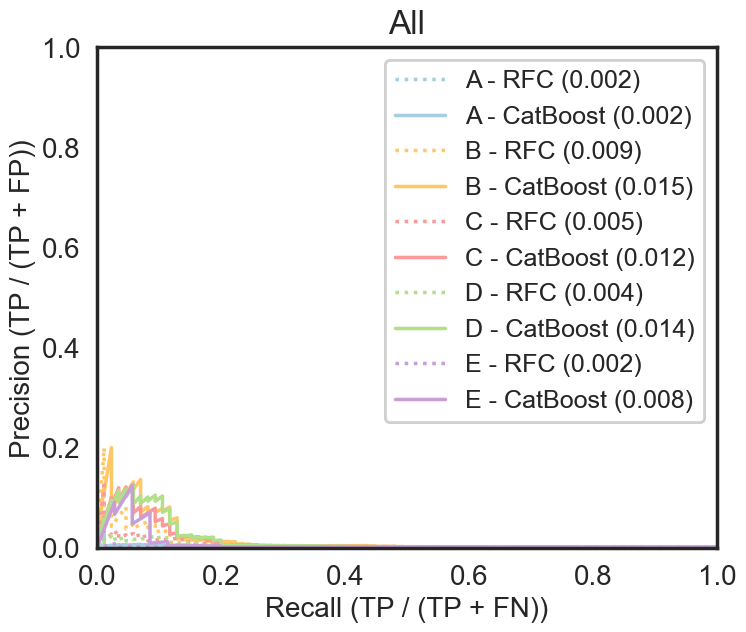

In [15]:

from modeling_pipeline import wrapper_violins_prcs


keys_ordered_all=["RFC_all_cca_Model_A","CatBoost_all_cca_Model_A", "RFC_all_cca_Model_B","CatBoost_all_cca_Model_B", "RFC_all_cca_Model_C","CatBoost_all_cca_Model_C", "RFC_all_cca_Model_D","CatBoost_all_cca_Model_D", "RFC_all_cca_Model_E","CatBoost_all_cca_Model_E",]

colors = {key: colors_PRC[key] for key in keys_ordered_all}
fig_all, ax_all = plt.subplots()

wrapper_violins_prcs.plot_precision_recall_curves(all_preds, keys_ordered_all, colors, fig=fig_all, ax=ax_all,truth="status_cancerreg", xlim = (0, 1), ylim=(0,1), display= "All", fill_bet=False, title='All', fig_path=AUPRC_path,
    external_keys=None)


Saved precision-recall curve to: C:/Users/felix/OneDrive - Uniklinik RWTH Aachen/CRC-1382-A11 - drive/public/projects/cca/visuals/AUPRCs\Prec_Recall_PAR_(0, 1).svg


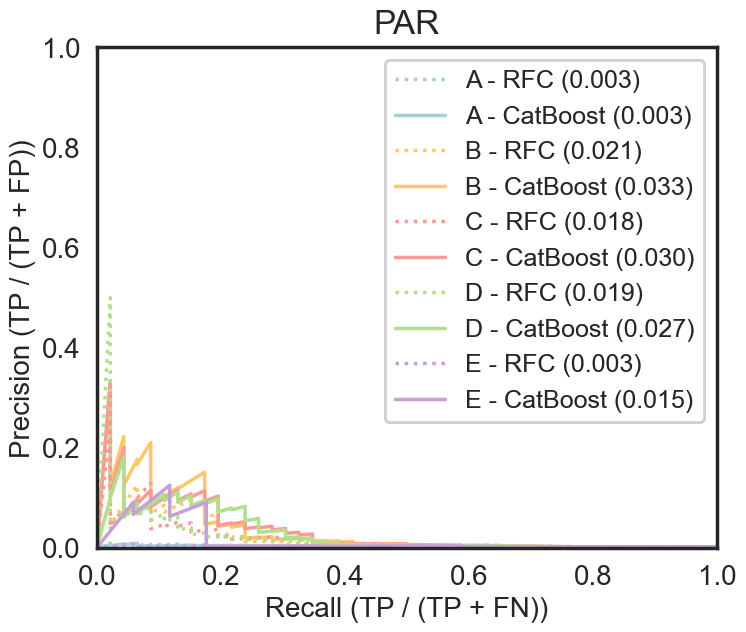

In [16]:

from modeling_pipeline import wrapper_violins_prcs


keys_ordered_all=["RFC_par_cca_Model_A","CatBoost_par_cca_Model_A", "RFC_par_cca_Model_B","CatBoost_par_cca_Model_B", "RFC_par_cca_Model_C","CatBoost_par_cca_Model_C", "RFC_par_cca_Model_D","CatBoost_par_cca_Model_D", "RFC_par_cca_Model_E","CatBoost_par_cca_Model_E",]

colors = {key: colors_PRC[key] for key in keys_ordered_all}
fig_all, ax_all = plt.subplots()

wrapper_violins_prcs.plot_precision_recall_curves(all_preds, keys_ordered_all, colors, fig=fig_all, ax=ax_all,truth="status_cancerreg", xlim = (0, 1), ylim=(0, 1 ), display= "PAR", fill_bet=False, title='PAR', fig_path=AUPRC_path,
    external_keys=None)


Saved precision-recall curve to: C:/Users/felix/OneDrive - Uniklinik RWTH Aachen/CRC-1382-A11 - drive/public/projects/cca/visuals/AUPRCs\Prec_Recall_Unscreened_(0, 0.5).svg


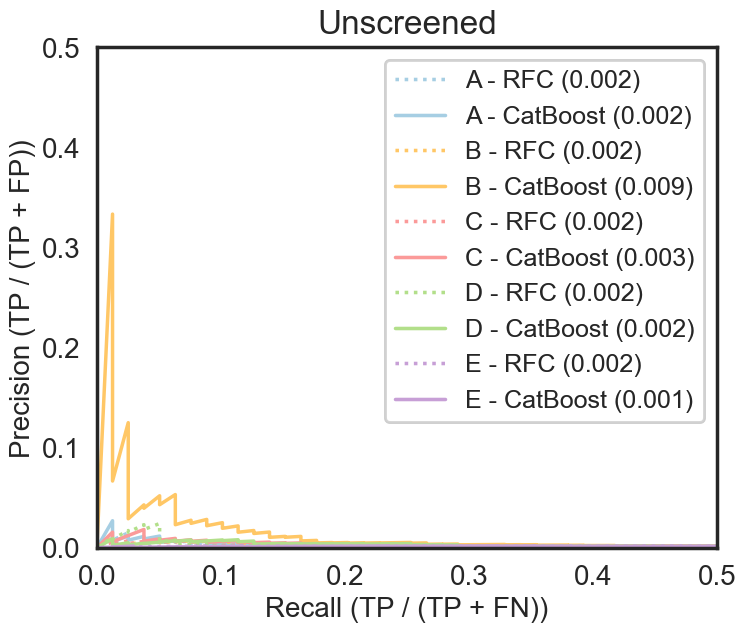

In [14]:

from modeling_pipeline import wrapper_violins_prcs


keys_ordered_all=["RFC_unscreened_cca_Model_A","CatBoost_unscreened_cca_Model_A", "RFC_unscreened_cca_Model_B","CatBoost_unscreened_cca_Model_B", "RFC_unscreened_cca_Model_C","CatBoost_unscreened_cca_Model_C", "RFC_unscreened_cca_Model_D","CatBoost_unscreened_cca_Model_D", "RFC_unscreened_cca_Model_E","CatBoost_unscreened_cca_Model_E",]

colors = {key: colors_PRC[key] for key in keys_ordered_all}
fig_all, ax_all = plt.subplots()

wrapper_violins_prcs.plot_precision_recall_curves(all_preds, keys_ordered_all, colors, fig=fig_all, ax=ax_all,truth="status_cancerreg", xlim = (0, 0.5), ylim=(0,0.5 ), display= "Unscreened", fill_bet=False, title='Unscreened', fig_path=AUPRC_path,
    external_keys=None)



In [ ]:



external_line_styles = {
    'AOU_all_cca_Model_TOP10_RFC_model_mean': ':',
    'AOU_all_cca_Model_TOP5_CatBoost_model_mean': '-',
    'AOU_all_cca_Model_TOP5_RFC_model_mean': ':',
    'AOU_all_cca_Model_TOP10_CatBoost_model_mean': '-'
}

